# Мы попробуем использовать все известные нам методы кластеризации и посмотрим на получившиеся результаты.
В нашем распоряжении есть данные о 8950 держателях кредитных карт одного из банков Нью-Йорка. Банк собрал достаточно много данных об этих людях и о том, как они пользовались кредитными картами за последние полгода.

Маркетологи хотят запустить рекламную кампанию, однако для этого необходимо произвести сегментацию клиентов, чтобы сделать акционное предложение более персонализированным.

In [4]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output='pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook') 
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8) 

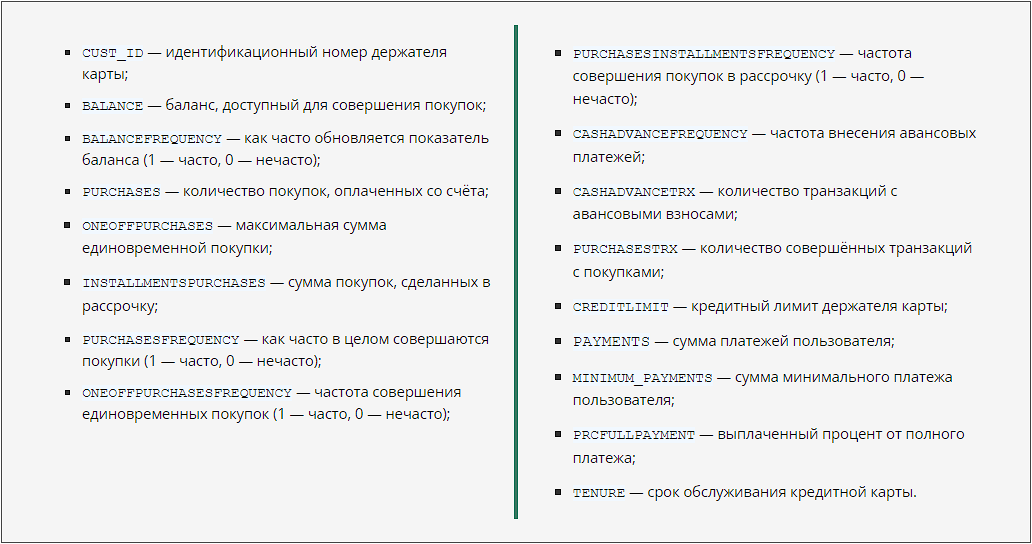

In [6]:
df = pd.read_csv('data/CC_GENERAL.zip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

### Задание 7.2

Теперь приступим к анализу данных. По традиции начнём его с проверки данных на наличие пропущенных значений. Сколько всего пропусков в данных?

In [7]:
df.isnull().sum().sum()

314

In [8]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

### Задание 7.3
Заполните все пропуски средними арифметическими для признаков. Каким будет среднее арифметическое для признака MINIMUM_PAYMENTS (если считать после заполнения пропущенных значений)? Округлите результат до двух знаков после точки-разделителя.

In [9]:
df.fillna(value={'CREDIT_LIMIT': df['CREDIT_LIMIT'].mean(), 
                 'MINIMUM_PAYMENTS': df['MINIMUM_PAYMENTS'].mean()}, inplace=True)

In [10]:
round(df['MINIMUM_PAYMENTS'].mean(), 2)

864.21

### Проверка уникальности признаков

In [11]:
(df.nunique() / df.shape[0] * 100).to_frame().round(2)

,0
CUST_ID,100.00
BALANCE,99.12
BALANCE_FREQUENCY,0.48
PURCHASES,69.31
ONEOFF_PURCHASES,44.85
INSTALLMENTS_PURCHASES,49.74
CASH_ADVANCE,48.30
PURCHASES_FREQUENCY,0.53
ONEOFF_PURCHASES_FREQUENCY,0.53
PURCHASES_INSTALLMENTS_FREQUENCY,0.53


Удаляю CUST_ID он не несет никакой информации, просто номер клиента

In [12]:
df.drop(columns='CUST_ID', inplace=True)

### Задание 7.4
Теперь нормализуйте данные с помощью StandardScaler(). Для получившейся матрицы нормализованных признаков выведите самое первое значение в самой первой строке (X_norm[0][0]). Округлите до двух знаков после точки-разделителя.

In [13]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(df)

In [14]:
round(X_norm.iloc[0, 0], 2)

-0.73

### Задание 7.5
Теперь можем приступать к кластеризации. Начнём с самого простого и популярного метода — k-means. 

Для того чтобы его применить, необходимо узнать число кластеров. 

Наилучший способ сделать это — применить коэффициент силуэта. 

Найдите с его помощью оптимальное количество кластеров, перебрав диапазон от 2 до 9 включительно. 

В этом и следующем заданиях для параметра random_state возьмём значение 42.

In [15]:
from sklearn.cluster import KMeans

clusters = list(range(2, 10))

def get_inertia(cluster_num, X):
    k_means = KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
    return k_means.inertia_

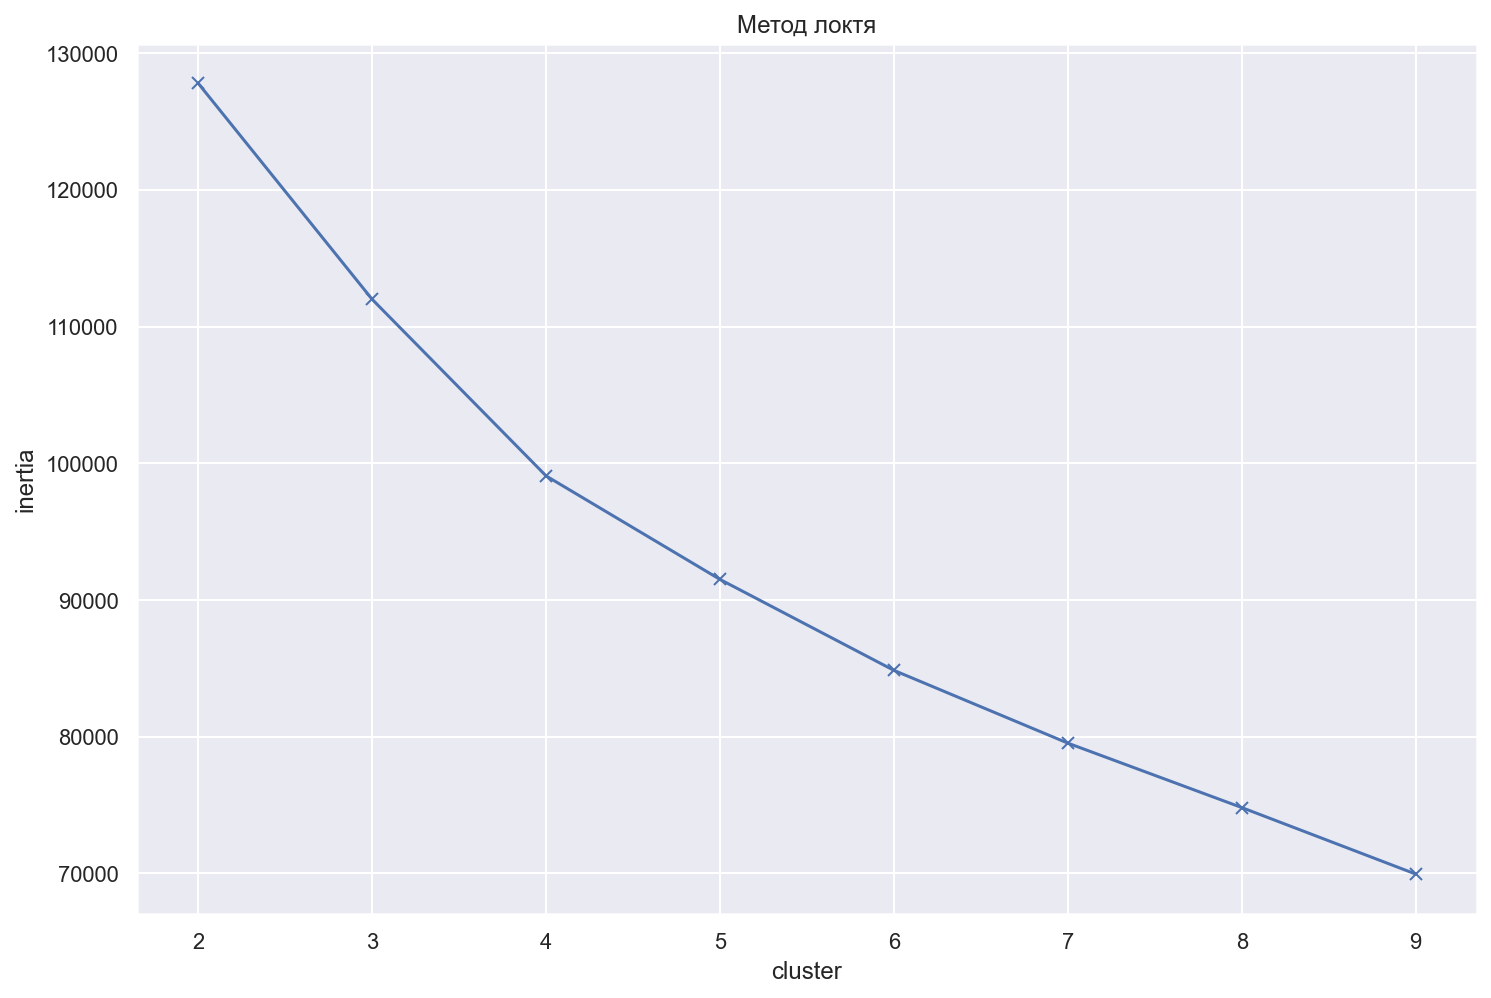

In [16]:
# создаём пустой список для значений инерции
inertia = []

for cluster_num in clusters:
    # сохраняем значения
    inertia.append(get_inertia(cluster_num, X_norm))
    
# визуализируем, как менялась инерция в зависимости от количества кластеров
# задаём названия осям x и y
plt.xlabel('cluster', fontsize=12)
plt.ylabel('inertia', fontsize=12)
plt.title('Метод локтя')
plt.plot(clusters, inertia, 'xb-');

In [17]:
# импортируем метрику силуэта
from sklearn.metrics import silhouette_score

def get_silhouette(cluster_num, X):
    k_means = KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
    return silhouette_score(X, k_means.labels_)

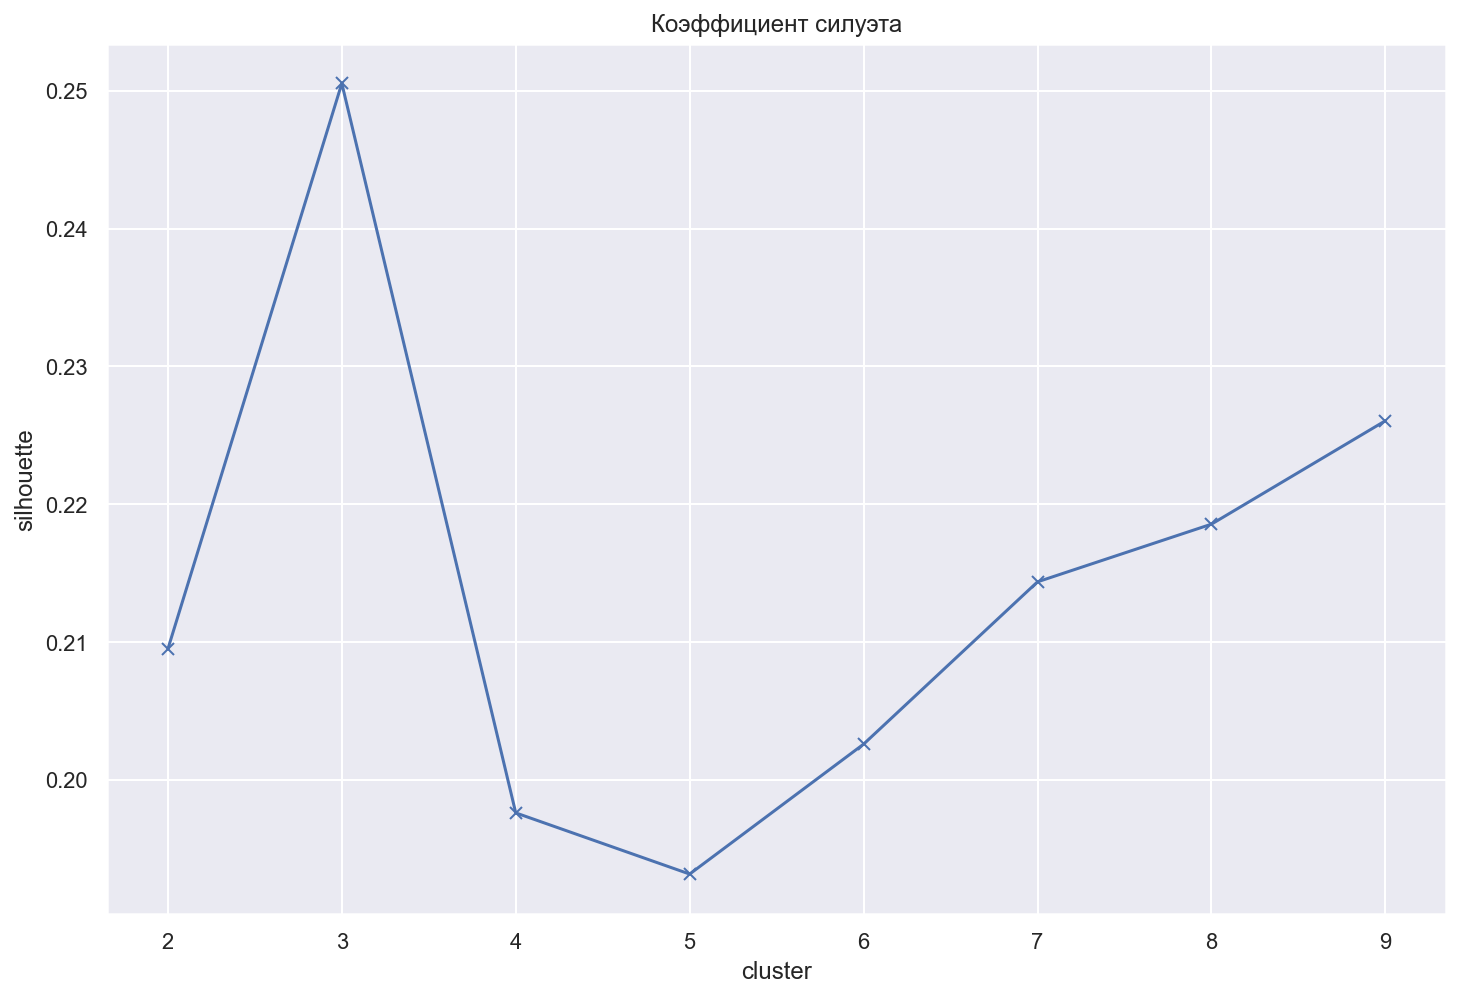

In [19]:
silhouette = []

for clust_num in clusters:
 silhouette.append(get_silhouette(clust_num, X_norm))
 
# визуализируем коэффициенты силуэта для разного количества кластеров
plt.xlabel('cluster', fontsize=12)
plt.ylabel('silhouette', fontsize=12)
plt.title('Коэффициент силуэта')
plt.plot(clusters, silhouette, 'xb-');

### Задание 7.6
Теперь реализуем непосредственно кластеризацию k-means с оптимальным количеством кластеров, которое мы определили в предыдущем задании.

Сколько человек оказалось в самой малочисленной группе?

In [20]:
k_means = KMeans(n_clusters=3, random_state=42)
k_means.fit(X_norm)

KMeans(n_clusters=3, random_state=42)

In [21]:
labels = k_means.predict(X_norm)
pd.Series(labels).value_counts()

0    6118
1    1597
2    1235
Name: count, dtype: int64

### Задание 7.7
Попробуем применить DBSCAN. Для начала реализуйте его с параметрами по умолчанию.

Сколько кластеров было выделено?

In [22]:
from sklearn.cluster import DBSCAN

model = DBSCAN()
model.fit(X_norm)

labels = model.labels_
pd.Series(labels).value_counts()

-1     6627
 0     1698
 5      234
 11      60
 2       34
 17      30
 15      23
 8       23
 16      18
 9       14
 7       13
 3       11
 31      10
 6        9
 23       9
 1        8
 10       8
 28       8
 29       7
 21       7
 19       7
 12       7
 14       6
 13       6
 4        6
 25       6
 37       5
 18       5
 20       5
 27       5
 26       5
 30       5
 33       5
 22       5
 24       5
 32       5
 36       4
 34       4
 35       3
Name: count, dtype: int64

In [23]:
pd.Series(labels).value_counts().shape[0]

39

### Задание 7.8
В предыдущем задании получилось очень много кластеров. Возможно, это случилось потому, 

что мы взяли параметры по умолчанию, а результат алгоритма DBSCAN, как вы помните, очень чувствителен к ним.

Давайте попробуем с помощью цикла перебрать параметр eps по значениям, заданным как np.arange(0.1,3,0.2), 

а параметр min_samples — по значениям, заданным как range(1,20,4). 

Найдите комбинацию, которая даёт максимальное значение коэффициента силуэта.

In [24]:
from itertools import product

eps_range = np.arange(0.1, 3, 0.2)
min_samples_range = list(range(1, 20, 4))

parameter_grid = list(product(eps_range, min_samples_range))

In [25]:
def get_silhouette_DBSCAN(X, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(X)
    return silhouette_score(X, model.labels_)

In [26]:
silhouette = []
parameter_labels = []

for eps, min_samples in parameter_grid:
    silhouette.append(get_silhouette_DBSCAN(X_norm, eps, min_samples))
    parameter_labels.append(f'{eps:.2f}, {min_samples:.0f}')

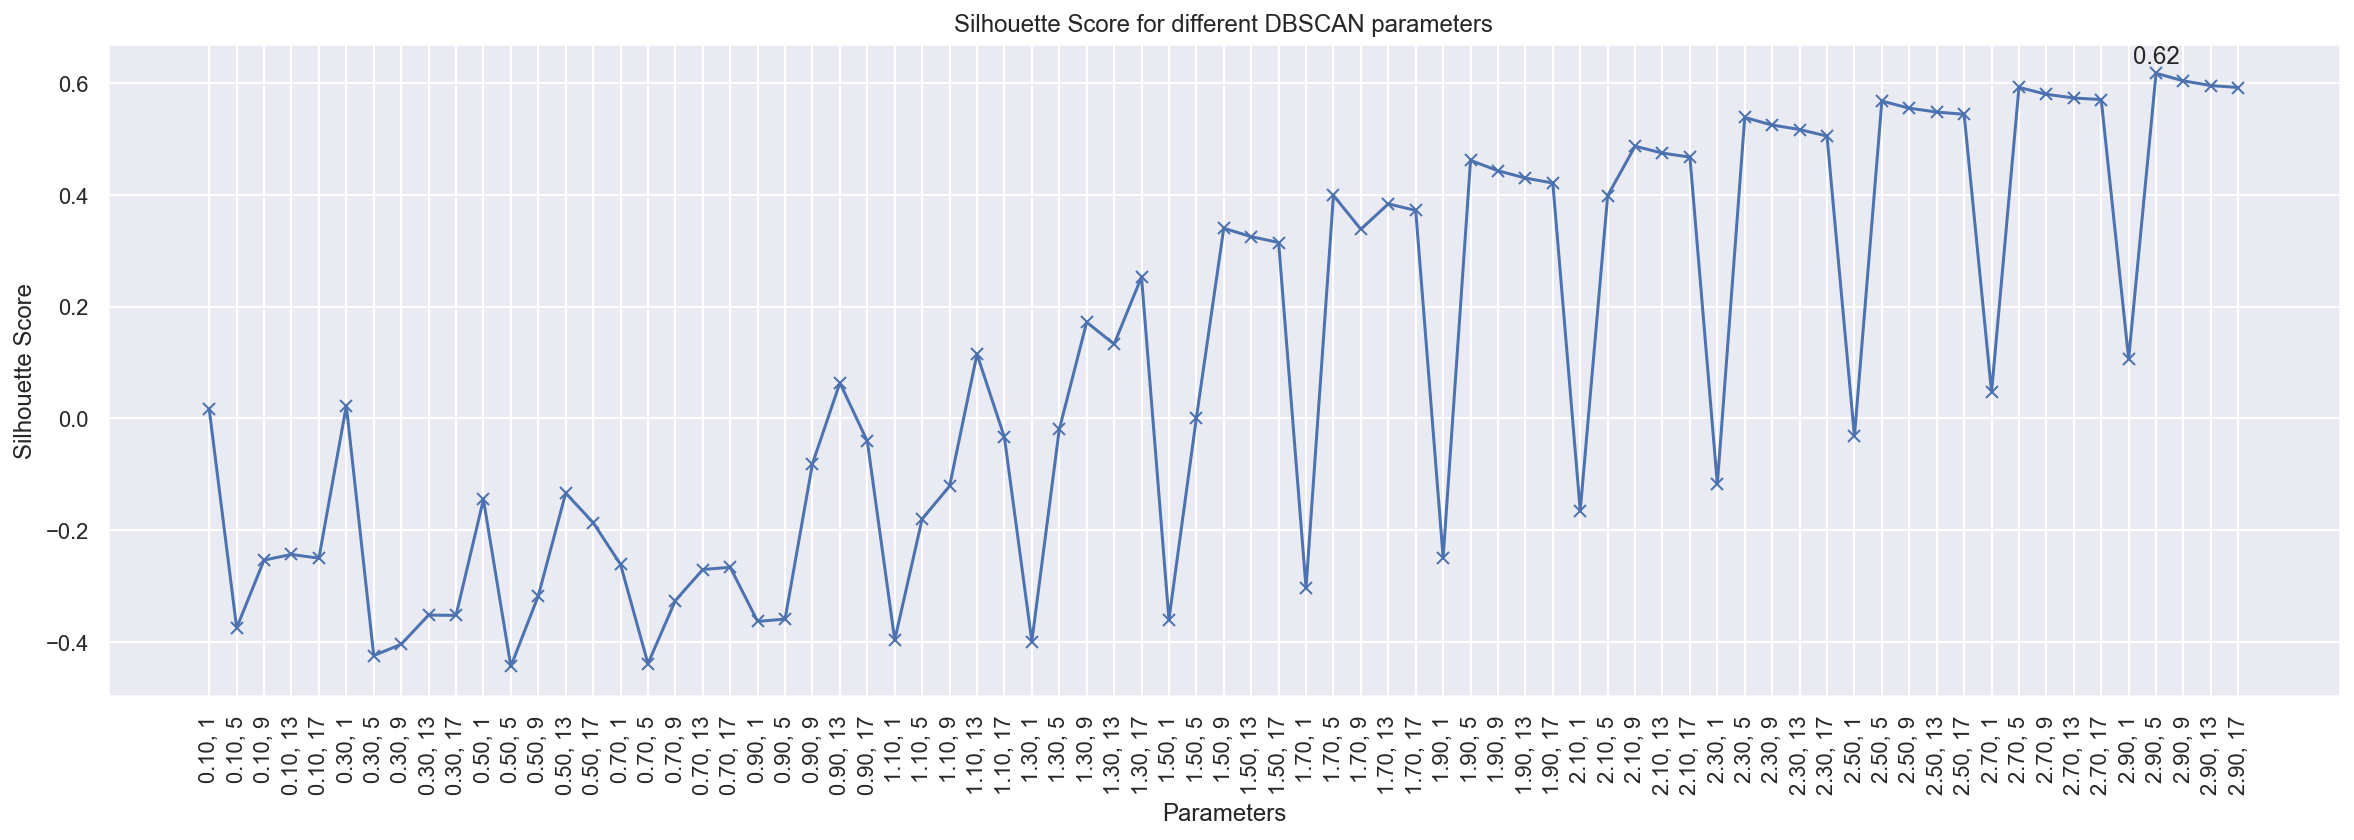

In [27]:
plt.figure(figsize=(20, 6))
plt.xlabel('Parameters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for different DBSCAN parameters')
plt.xticks(rotation=90)
plt.plot(parameter_labels, silhouette, 'xb-')

# Find the index of the max silhouette score
max_score_index = np.argmax(silhouette)
# Add text for the max silhouette score
plt.text(parameter_labels[max_score_index], silhouette[max_score_index] * 1.03, f'{silhouette[max_score_index]:.2f}', ha='center')
plt.show()

In [28]:
model = DBSCAN(eps=2.9, min_samples=5)
model.fit(X_norm)
round(silhouette_score(X_norm, model.labels_), 2)

0.62

### Задание 7.9
Теперь давайте реализуем агломеративную иерархическую кластеризацию.

Переберите количество кластеров в диапазоне от 3 до 9 включительно и найдите то их число, которое будет давать максимальный коэффициент силуэта.

In [29]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
def get_silhouette(X, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(X)
    return silhouette_score(X, model.labels_)

In [31]:
clusters = list(range(3, 10))
silhouette = []

for n_clusters in clusters:
    silhouette.append(get_silhouette(X_norm, n_clusters))

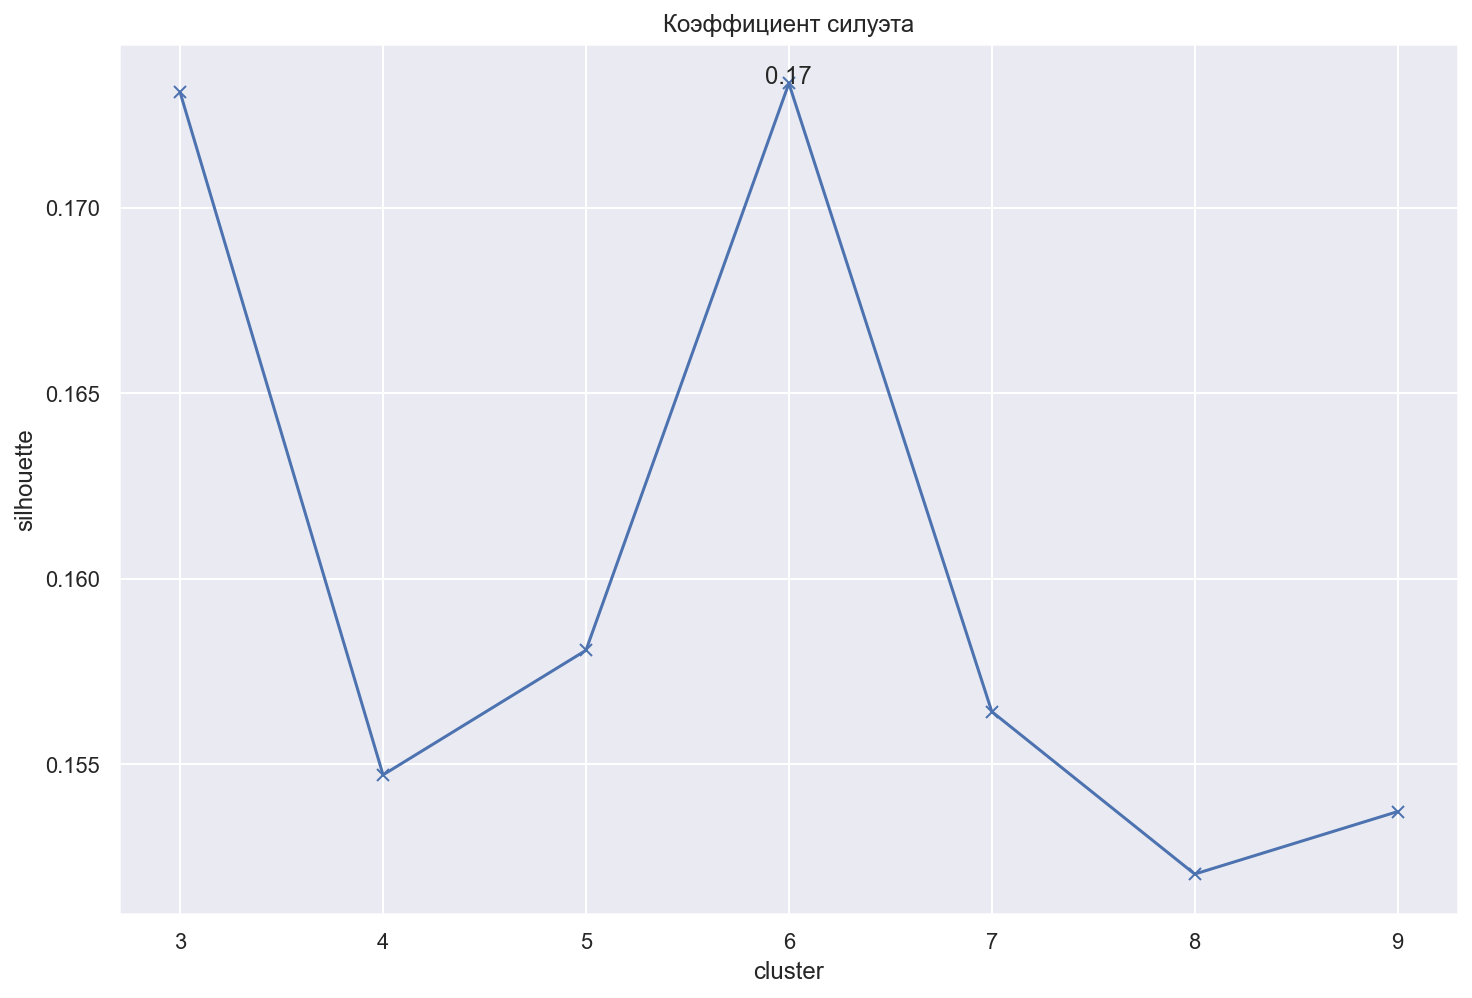

In [32]:
# визуализируем коэффициенты силуэта для разного количества кластеров
plt.xlabel('cluster', fontsize=12)
plt.ylabel('silhouette', fontsize=12)
plt.title('Коэффициент силуэта')
plt.plot(clusters, silhouette, 'xb-')

# Find the index of the max silhouette score
max_score_index = np.argmax(silhouette)
# Add text for the max silhouette score
plt.text(clusters[max_score_index], silhouette[max_score_index], f'{silhouette[max_score_index]:.2f}', ha='center')
plt.show()

### Задание 7.10
Сколько будет наблюдений в самом многочисленном классе, если мы обучим на наших данных модель агломеративной иерархической кластеризации с количеством кластеров, полученным в предыдущем задании?

In [33]:
model = AgglomerativeClustering(n_clusters=6)
model.fit(X_norm)
pd.Series(model.labels_).value_counts()

0    3946
1    2931
2     864
5     722
3     464
4      23
Name: count, dtype: int64

Давайте визуализируем результаты кластеризации k-means, отобразив два признака — количество покупок и кредитный лимит:

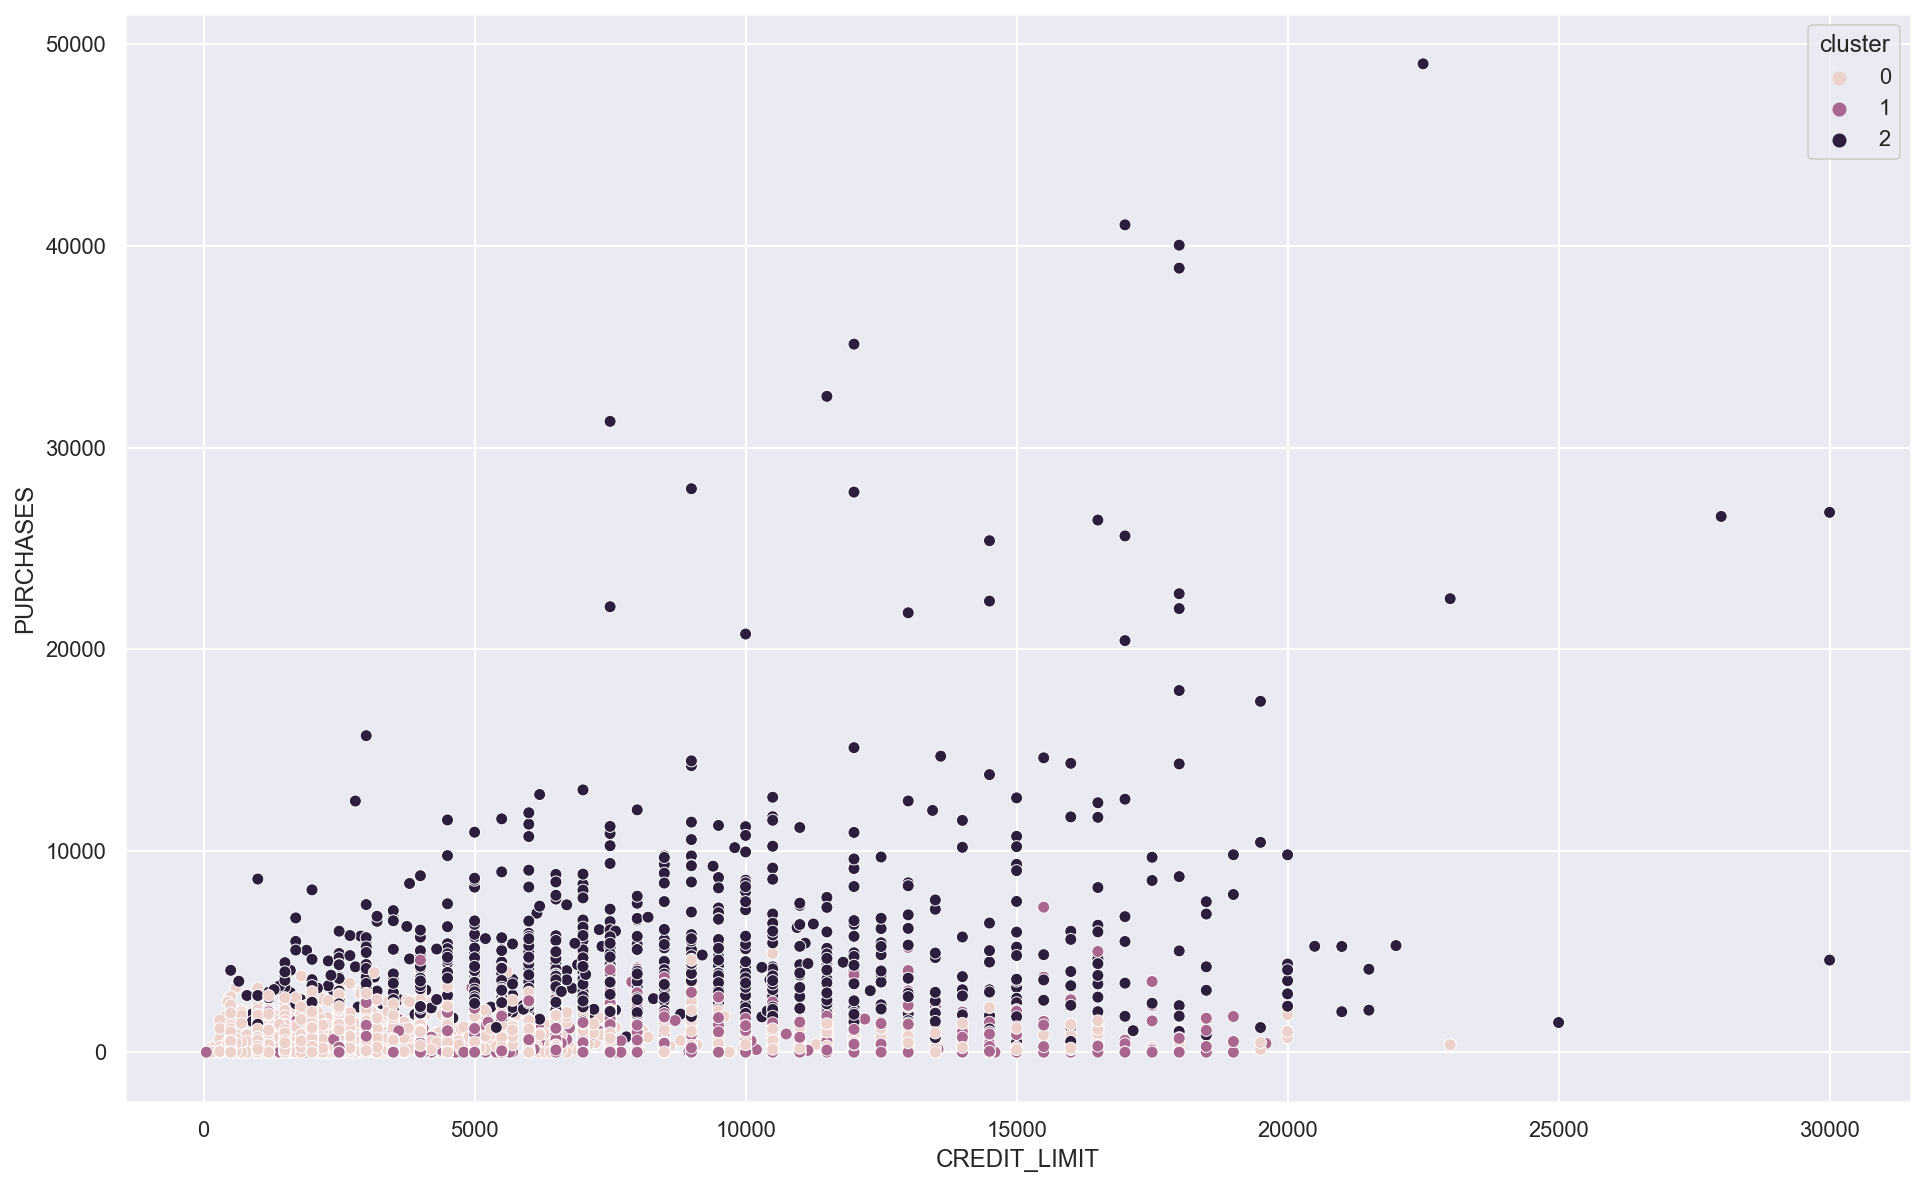

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_norm)

df['cluster'] = kmeans.labels_
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster')
plt.show()

### Визуализация силуэтов

Average silhouette score:  0.2505299806322502


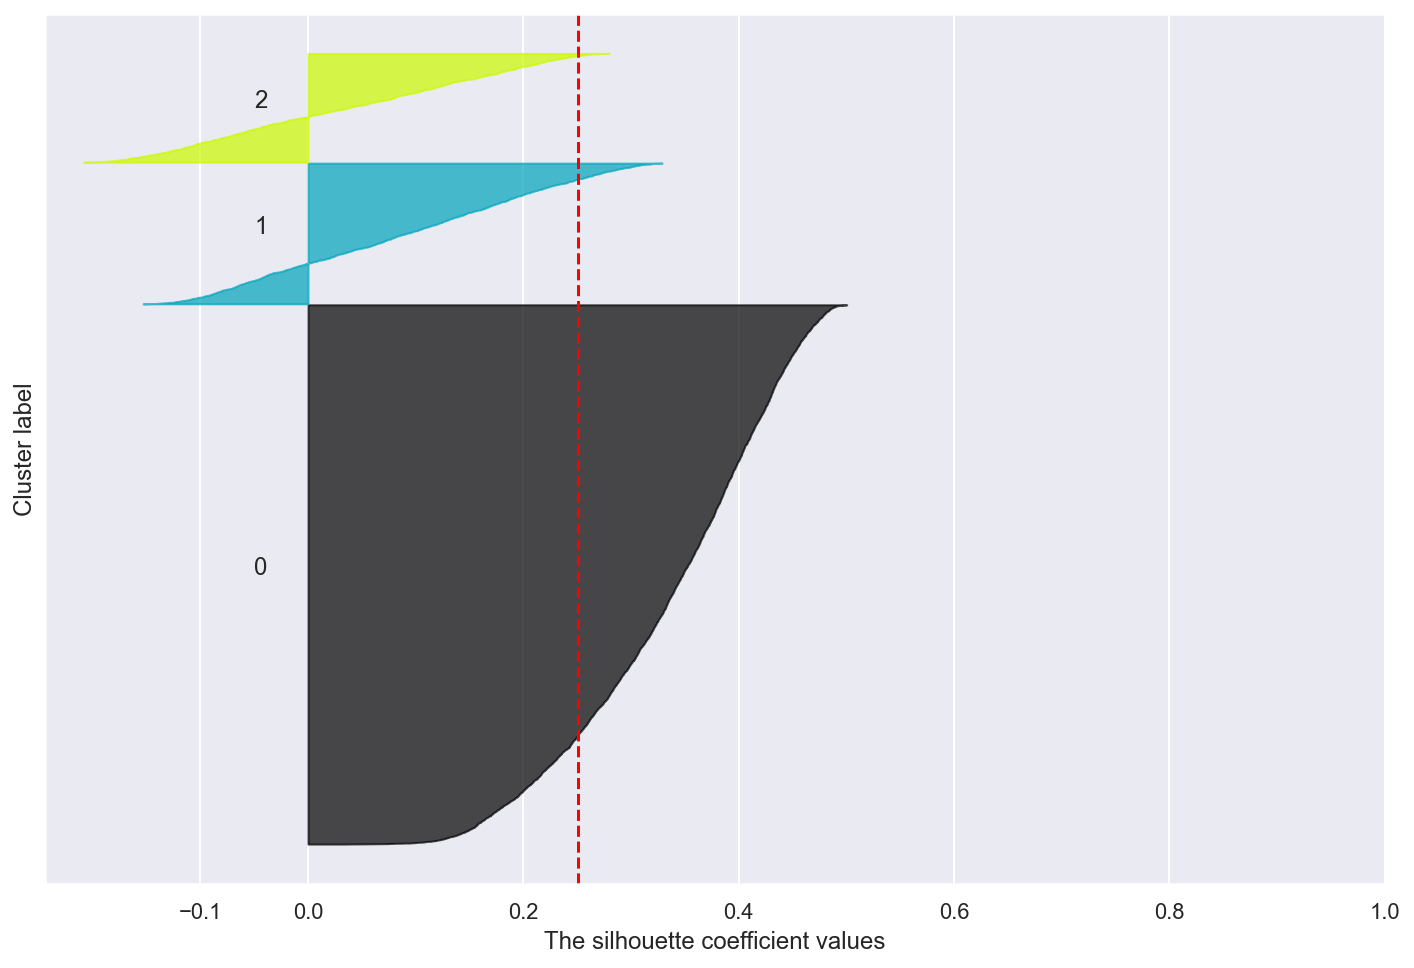

In [38]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm

# Get the DBSCAN model with the optimal parameters obtained from Grid Search
model = KMeans(n_clusters=3, random_state=42)
labels = model.fit_predict(X_norm)

# Get silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_norm, labels)

fig, ax = plt.subplots()
y_lower = 10  # For space between silhouette plots

# Get the average silhouette score and print it
average_silhouette_score = silhouette_score(X_norm, labels)
print("Average silhouette score: ", average_silhouette_score)

# For each cluster (ignoring noise if present)
for i in np.unique(labels):
    if i != -1:  # excluding noise
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(np.unique(labels)))
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=average_silhouette_score, color="red", linestyle="--")

ax.set_yticks([])  # Clear the y-axis labels
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()
